In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import scipy.stats
plt.style.use("../customstyle.mplstyle")

from statsmodels.stats.multitest import multipletests


colors = ["#" + x for x in ["000000","cf5c36","bcd696","7d4f7d","556B2F"]]
lcolors = ["#" + x for x in ["858585","e7af9c","e3eed3","cec5d3","90EE90"]] # light colors (for fill)

In [2]:
# Load inference data
#outdir = "C:/Users/pveron/Output_clusters/PBD_analog/12152"
outdir = "../simulations_output"

simul_infer = pd.read_csv(outdir + "/1-PBD/all_simulations_inference.csv")
simul_infer["combinaison"] = 10*simul_infer.param_vary + simul_infer.i_param_var

#summary_all_mcmc = pd.read_csv(outdir + "/summary_all_MCMC.csv")

n_rep = 1 + max(simul_infer.replicate)
n_val = max(simul_infer.i_param_var)
n_par = 5 
statsPBD = pd.read_csv(outdir + "/1-PBD/simulated_PDB_trees_stats.csv")
#statsPBD = statsPBD[statsPBD['replicate'] < 100]

statsBD = pd.read_csv(outdir + "/2-CBD/simulated_BD_trees_stats.csv")
#statsBD = statsBD[statsBD['replicate'] < 100]

statsVarBD = pd.read_csv(outdir + "/3-varBD/simulated_varBD_trees_stats.csv")

PBD_names = ["PBD." + s for s in ["l1", "l2", "l3", "mu1", "mu2"]]

In [3]:
# ---- Create vectors with summarized statistics ----
# Statistics to plot
statistics = ["SR", "gamma", "stairs2"]
models = ["PBD", "BD", "varBD"]
col_model = dict(PBD = [colors[0], lcolors[0]], 
                 BD = [colors[1], lcolors[1]], 
                 varBD = [colors[3], lcolors[3]]) 

qlow, qhigh = 0.25, 0.75 # lower and higher quantile to plot

name_stats = dict(SR = "Species richness", 
                  gamma = "$\\gamma$ statistics", 
                  stairs2 = "stairs2 statistics") # Ylabel
scale = dict(SR = "log", 
             gamma = "symlog", 
             stairs2 = "linear") # y scale 

# ---- Compute summary of stats ----
n_stats = len(statistics)

x = np.zeros((n_par, n_val))
median = np.zeros((n_par, n_val, n_stats, 3))
bottom_fill = np.zeros_like(median)
top_fill = np.zeros_like(median)
has_data = np.zeros((n_par, n_val, n_stats, 3), dtype = bool)
n_trees = np.zeros((n_par, n_val, n_stats, 3), dtype = int)

for i_par in range(n_par):
    for i_val in range(n_val):
        params = simul_infer.loc[(simul_infer.param_vary == i_par + 1) & 
                                 (simul_infer.i_param_var == i_val + 1) &
                                 (simul_infer.replicate == 0), PBD_names].to_dict("records")[0]
        statsPBD_config = statsPBD.loc[(statsPBD.param_vary == i_par + 1) & 
                                       (statsPBD.i_param_var == i_val + 1)]
        statsBD_config = statsBD.loc[(statsBD.param_vary == i_par + 1) & 
                                     (statsBD.i_param_var == i_val + 1 )]
        statsVarBD_config = statsVarBD.loc[(statsVarBD.param_vary == i_par + 1) & 
                                           (statsVarBD.i_param_var == i_val + 1 )]
        statsAll_config = (statsPBD_config, statsBD_config, statsVarBD_config)
        x[i_par, i_val] = params[PBD_names[i_par]]

        for i_stat, stat in enumerate(statistics):
            for i_model, stats_config in enumerate(statsAll_config):
                stat_val = stats_config[stat]
                stat_val = stat_val.loc[(np.isfinite(stat_val))] # remove nan
                n_trees[i_par, i_val, i_stat, i_model] = len(stat_val)
                if len(stat_val) > 0:
                    has_data[i_par, i_val, i_stat, i_model] = True
                    quant = np.quantile(stat_val, q = [qlow, 0.5, qhigh])

                    bottom_fill[i_par, i_val, i_stat, i_model] = quant[0]
                    median[i_par, i_val, i_stat, i_model] = quant[1]
                    top_fill[i_par, i_val, i_stat, i_model] = quant[2]
                else:
                    bottom_fill[i_par, i_val, i_stat, i_model] = np.nan
                    median[i_par, i_val, i_stat, i_model] = np.nan
                    top_fill[i_par, i_val, i_stat, i_model] = np.nan

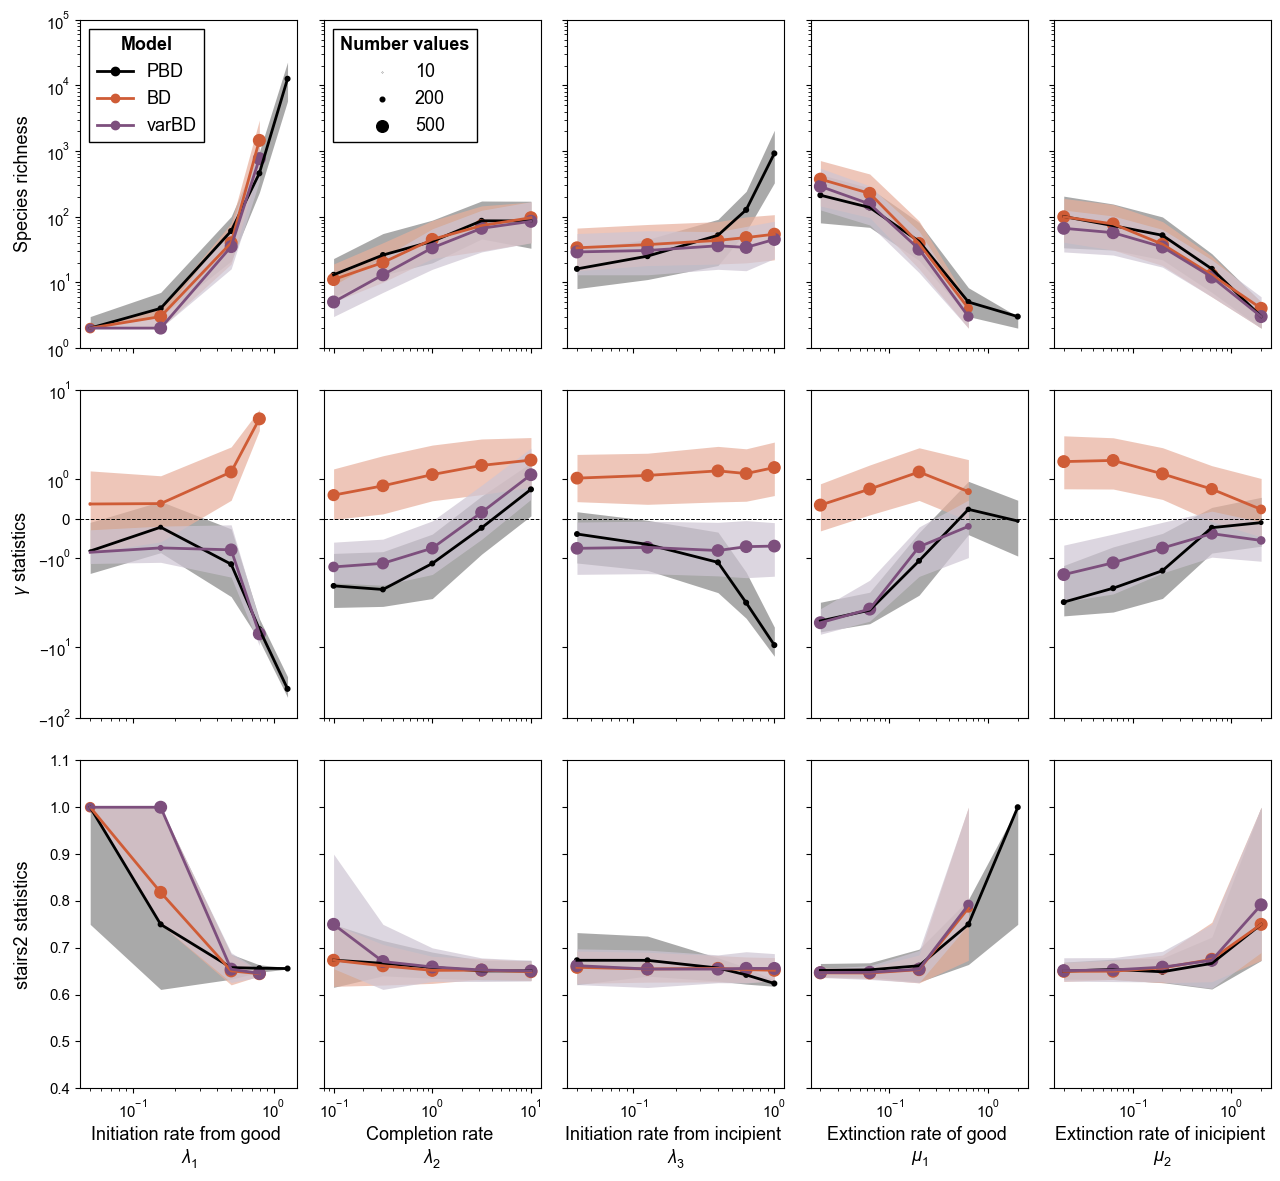

In [4]:
# ---- Plot figure ----
markersize = lambda n: 70*(n / 500)**2
fig, axes = plt.subplots(3, 5, figsize = (13, 12), sharex="col", sharey="row")

for i_stat, stat in enumerate(statistics):
    for i_par in range(n_val):
        ax = axes[i_stat, i_par]
        ax.set_xscale("log")

        for i_model, model in enumerate(models):
            ax.fill_between(x[i_par, :], 
                            bottom_fill[i_par, :, i_stat, i_model],
                            top_fill[i_par, :, i_stat, i_model], 
                            where = has_data[i_par, :, i_stat, i_model],
                            ec = col_model[model][1], 
                            fc = col_model[model][1],
                            lw = 0, 
                            alpha = 0.7)
        for i_model, model in enumerate(models):
            ax.plot(x[i_par, :], median[i_par, :, i_stat, i_model],
                    color = col_model[model][0], lw = 2)
            ax.scatter(x[i_par, :], median[i_par, :, i_stat, i_model],
                        color = col_model[model][0],marker = 'o', 
                        s = markersize(n_trees[i_par, :, i_stat, i_model]))

            
        if stat == "gamma":
            axes[i_stat, i_par].axhline(0, color = "k", lw = 0.7, ls = "--")
        
    axes[i_stat,0].set_yscale(scale[stat])
    axes[i_stat,0].set_ylabel(name_stats[stat])

legendstl = dict(loc = "upper left", title_fontproperties = dict(weight = 'bold'))

# Model legend
ax  = axes[0,0]
for i_model, model in enumerate(models):
    ax.plot([],[], marker = "o", color = col_model[model][0], lw = 2, label = model)
ax.legend(title = "Model", **legendstl)

# Markersize legend
ax = axes[0,1]
for n in [10,200,500]:
    ax.scatter([],[], color = "k", marker = "o",s = markersize(n), 
            label = str(n))
ax.legend(title = "Number values", **legendstl)

axes[-1,0].set_xlabel("Initiation rate from good \n$\lambda_1$")
axes[-1,1].set_xlabel("Completion rate \n$\lambda_2$")
axes[-1,2].set_xlabel("Initiation rate from incipient \n$\lambda_3$")
axes[-1,3].set_xlabel("Extinction rate of good \n$\mu_1$")
axes[-1,4].set_xlabel("Extinction rate of inicipient \n$\mu_2$")
axes[0,0].set_ylim(1,1e5)
axes[1,0].set_ylim(-100,10)
axes[2,0].set_ylim(0.4,1.1)
fig.align_labels()
plt.savefig("../fig/statistics_tree.pdf");